In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
from google.colab import files
files.upload()
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d puneet6060/intel-image-classification

Saving kaggle.json to kaggle.json
 96% 331M/346M [00:01<00:00, 253MB/s]
100% 346M/346M [00:01<00:00, 220MB/s]


In [ ]:
!unzip "intel-image-classification.zip"

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [ ]:
import keras
import tensorflow as tf
from keras.layers import Conv2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import MaxPool2D,Dropout
from keras.layers import Flatten
from keras.layers.normalization import BatchNormalization

In [ ]:
model = Sequential()
# Adding the 1st CNN layer filter size (150x150x3) kernel size (10x10) strides (4,4) depth(96)
model.add(Conv2D(96,kernel_size=(10,10),strides=(4,4),input_shape=(150,150,3),padding="valid",activation="relu"))   # this gives input_size = 36x36
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid')) #this gives input_size = 18x18
# Batch Normalisation
model.add(BatchNormalization())

# Adding the 2nd CNN layer kernel_size (5x5) depth 256 strides(1x1)
model.add(Conv2D(256,kernel_size=(5,5),strides=(1,1),padding='same',activation='relu')) # this gives 14x14 and by keeping the padding same it will be 18x18
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2),padding='valid')) #this gives 9x9
# Batch Normalisation
model.add(BatchNormalization())

# Adding the 3rd CNN layer kernel_size (3x3) depth 384 strides(1x1) padding same
model.add(Conv2D(384,kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')) # this gives 9x9
# Batch Normalisation
model.add(BatchNormalization())

# Adding the 4th CNN layer kernel_size (3x3) depth 384 strides(1x1) padding same
model.add(Conv2D(384,kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')) # this gives 9x9
# Batch Normalisation
model.add(BatchNormalization())

# Adding the 5th CNN layer kernel_size (3x3) depth 256 strides(1x1) padding same
model.add(Conv2D(256,kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')) # this gives 9x9
model.add(MaxPool2D(pool_size=(3,3),strides=(2,2), padding='valid')) # this gives 4x4
# Batch Normalisation
model.add(BatchNormalization())

# Passing it to a dense layer
model.add(Flatten())



In [ ]:
model.output_shape

(None, 4096)

In [ ]:
# 1st Dense Layer
model.add(Dense(4096, input_shape=(150*150*3,),activation='relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096,activation="relu"))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(1000,activation='relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# Output Layer
model.add(Dense(6,activation='softmax'))

In [ ]:
model.output_shape

(None, 6)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 36, 36, 96)        28896     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 18, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 256)         1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 384)         8

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_path_dir='/content/seg_train/seg_train'
validation_path_dir='/content/seg_test/seg_test'

In [ ]:
training_set = train_datagen.flow_from_directory(train_path_dir,
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 14034 images belonging to 6 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(validation_path_dir,
                                            target_size = (150, 150),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 3000 images belonging to 6 classes.


In [ ]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch= int(14034/64),
  validation_steps=int(3000/64)
)

Epoch 1/30
219/219 [==============================] - 39s 178ms/step - loss: 1.4611 - accuracy: 0.5034 - val_loss: 2.9435 - val_accuracy: 0.3207
Epoch 2/30
219/219 [==============================] - 39s 178ms/step - loss: 1.0799 - accuracy: 0.6087 - val_loss: 1.5648 - val_accuracy: 0.4769
Epoch 3/30
219/219 [==============================] - 39s 178ms/step - loss: 0.9531 - accuracy: 0.6573 - val_loss: 0.9613 - val_accuracy: 0.6481
Epoch 4/30
219/219 [==============================] - 39s 177ms/step - loss: 0.8667 - accuracy: 0.6882 - val_loss: 2.7958 - val_accuracy: 0.2853
Epoch 5/30
219/219 [==============================] - 39s 177ms/step - loss: 0.8043 - accuracy: 0.7070 - val_loss: 0.9475 - val_accuracy: 0.6909
Epoch 6/30
219/219 [==============================] - 39s 177ms/step - loss: 0.7649 - accuracy: 0.7245 - val_loss: 1.2709 - val_accuracy: 0.5788
Epoch 7/30
219/219 [==============================] - 39s 177ms/step - loss: 0.7159 - accuracy: 0.7459 - val_loss: 1.0686 - val_ac

In [ ]:
model.evaluate_generator(test_set)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.8943857550621033, 0.7153333425521851]

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

In [ ]:
def predict_(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (150,150))
    cv2_imshow(image)
    #predict the image
    preds = model.predict(np.expand_dims(image, axis=0))[0].tolist()
    preds = int(preds[0])
    print(preds)

In [ ]:
path = "/content/seg_pred/seg_pred/"

In [ ]:
import os


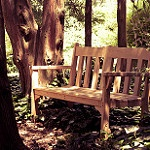

0


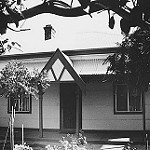

1


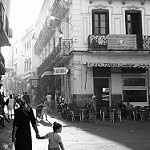

1


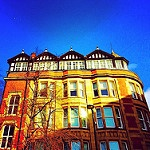

1


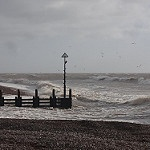

1


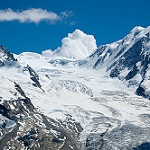

1


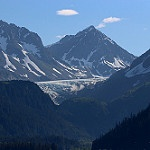

1


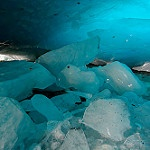

1


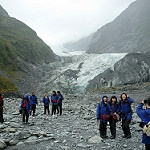

1


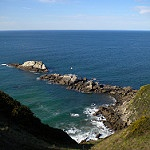

1


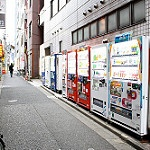

1


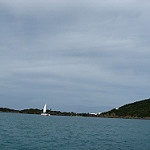

1


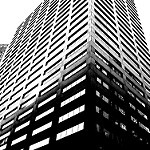

1


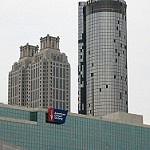

1


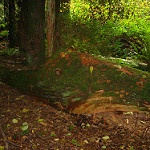

1


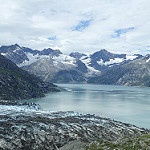

1


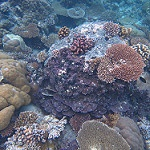

1


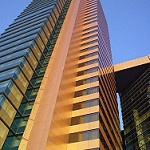

1


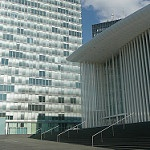

1


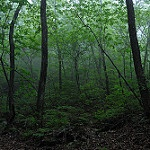

0


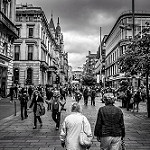

0


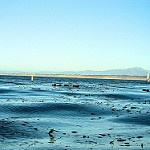

1


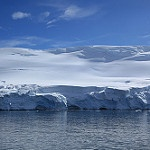

1


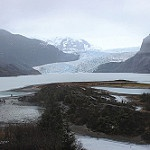

1


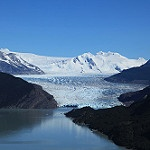

1


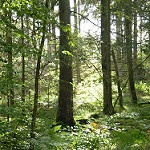

0


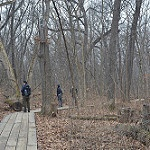

1


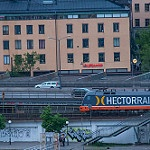

1


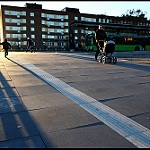

0


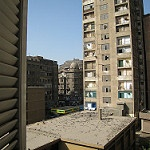

1


In [ ]:
count = 0
for filename in os.listdir(path):
  if count<30:
    predict_(path+filename)
    count+=1